In [1]:
import os
import re

from IPython.display import clear_output
from random import sample

import re

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
with open('datasets/author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [line.lower() for line in quotes]

In [3]:
quotes[:5]

['if you live to be a hundred, i want to live to be a hundred minus one day so i never have to live without you.',
 "promise me you'll always remember: you're braver than you believe, and stronger than you seem, and smarter than you think.",
 'did you ever stop to think, and forget to start again?',
 'organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 'weeds are flowers too, once you get to know them.']

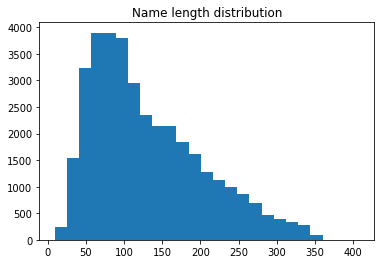

In [4]:
plt.title('Name length distribution')
plt.hist(list(map(len, quotes)), bins=25);

In [5]:
def clean(text):
    result = []
    for sentence in text:
        sentence = re.sub('[^\-a-zA-Z\']',' ', sentence)
        sentence = re.sub('\'ll',' will',sentence)
        sentence = re.sub('\'t',' not',sentence)
        sentence = re.sub('\'d',' would',sentence)
        sentence = re.sub('\'s',' is',sentence)
        sentence = re.sub('\'m',' am',sentence)
        sentence = re.sub('\'re',' are',sentence)
        sentence = re.sub('\'',' ',sentence)
        sentence = re.sub(' - ',' ',sentence)
        sentence = re.sub(' +', ' ',sentence)
        result.append(sentence)
    return result

In [6]:
quotes = clean(quotes)
quotes[:5]

['if you live to be a hundred i want to live to be a hundred minus one day so i never have to live without you ',
 'promise me you will always remember you are braver than you believe and stronger than you seem and smarter than you think ',
 'did you ever stop to think and forget to start again ',
 'organizing is what you do before you do something so that when you do it it is not all mixed up ',
 'weeds are flowers too once you get to know them ']

In [7]:
tok_sent = []
for i in quotes:
    i = i.split()
    tok_sent.append(i)
tok_sent[:5]

[['if',
  'you',
  'live',
  'to',
  'be',
  'a',
  'hundred',
  'i',
  'want',
  'to',
  'live',
  'to',
  'be',
  'a',
  'hundred',
  'minus',
  'one',
  'day',
  'so',
  'i',
  'never',
  'have',
  'to',
  'live',
  'without',
  'you'],
 ['promise',
  'me',
  'you',
  'will',
  'always',
  'remember',
  'you',
  'are',
  'braver',
  'than',
  'you',
  'believe',
  'and',
  'stronger',
  'than',
  'you',
  'seem',
  'and',
  'smarter',
  'than',
  'you',
  'think'],
 ['did',
  'you',
  'ever',
  'stop',
  'to',
  'think',
  'and',
  'forget',
  'to',
  'start',
  'again'],
 ['organizing',
  'is',
  'what',
  'you',
  'do',
  'before',
  'you',
  'do',
  'something',
  'so',
  'that',
  'when',
  'you',
  'do',
  'it',
  'it',
  'is',
  'not',
  'all',
  'mixed',
  'up'],
 ['weeds',
  'are',
  'flowers',
  'too',
  'once',
  'you',
  'get',
  'to',
  'know',
  'them']]

In [8]:
tokens = list(set([item for sublist in tok_sent for item in sublist]))
tokens = [' ']+tokens
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens)

In [9]:
print('Количество уникальных токенов: ', num_tokens)

Количество уникальных токенов:  27984


In [10]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [11]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype)

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
       
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [12]:
#Example: cast 4 names to matrices, pad with zeros
print(tok_sent[:3])
print(to_matrix(tok_sent[:3], token_to_id))

[['if', 'you', 'live', 'to', 'be', 'a', 'hundred', 'i', 'want', 'to', 'live', 'to', 'be', 'a', 'hundred', 'minus', 'one', 'day', 'so', 'i', 'never', 'have', 'to', 'live', 'without', 'you'], ['promise', 'me', 'you', 'will', 'always', 'remember', 'you', 'are', 'braver', 'than', 'you', 'believe', 'and', 'stronger', 'than', 'you', 'seem', 'and', 'smarter', 'than', 'you', 'think'], ['did', 'you', 'ever', 'stop', 'to', 'think', 'and', 'forget', 'to', 'start', 'again']]
[[ 6876 24582  8416   906 12746   369 16687 17060 23083   906  8416   906
  12746   369 16687 21150 24240 25319  4053 17060  7897  2504   906  8416
   8820 24582]
 [25203  7449 24582 11396 13314  2402 24582  9614  6795 25429 24582  3213
   9775  1918 25429 24582 20700  9775  4638 25429 24582 14158     0     0
      0     0]
 [21277 24582 10884  1680   906 14158  9775 18590   906  9261  2822     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [13]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [14]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

        
    def forward(self, x, hidden_state=None):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        if hidden_state is not None:
            h_seq, new_hidden = self.rnn(self.emb(x), hidden_state)
        else:
            h_seq, new_hidden = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, new_hidden
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())

In [15]:
batches = [tok_sent[i] for i in range(0,len(tok_sent),len(tok_sent)//300)]

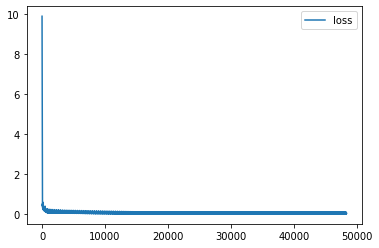

 61%|██████▏   | 185/302 [04:08<02:03,  1.06s/it]

KeyboardInterrupt: 

In [16]:
%%time

MAX_LENGTH = max(map(len, tok_sent))


history = []
for i in range(1001):
    if i != 0:
        model.load_state_dict(torch.load('weights_only.pth'))
    else:
        pass
    
    for batch in tqdm(batches):
        batch_ix = to_matrix(batch, token_to_id, max_len=MAX_LENGTH)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        logp_seq = model(batch_ix)[0]

        # compute loss
        predictions_logp = logp_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]

        loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))

        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        torch.save(model.state_dict(), 'weights_only.pth')

        history.append(loss.data.numpy())
        if (i + 1) % 10 == 0:
            clear_output(True)
            plt.plot(history, label='loss')
            plt.legend()
            plt.show()
assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [17]:
model.load_state_dict(torch.load('weights_only.pth'))

<All keys matched successfully>

In [18]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [[token_to_id[token] for token in seed_phrase]]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    hidden_s = None
    for i in range(len(seed_phrase) - 1):
        _, hidden_s = model.forward(x_sequence[:, :, i], hidden_s)
    
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hidden_s = model.forward(x_sequence[:, :, -1], hidden_s)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next[0])
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
        
    return ' '.join([tokens[ix] for ix in x_sequence[0, 0].data.numpy()])
    #return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [20]:
for _ in range(10):
    print(''.join(generate_sample(model)))